In [1]:
! pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.9 MB/s eta 0:00:00


In [2]:
!pip install ydata_profiling --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.6/381.6 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is no

In [3]:
!pip install pysrt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
!pip install -U spacy --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 5.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.7.2 which is incompatible.


In [5]:
!pip install PyMuPDF --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 49.4 MB/s eta 0:00:00


In [6]:
!python -m spacy download en_core_web_sm --quiet

2023-11-19 10:28:42.876150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 10:28:42.876215: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 10:28:42.876261: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 10:28:42.887645: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-19 10:28:44.854713: W tensorflow/compiler/

In [7]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00


# Determining level of English language in movies

**Description:** Watching movies in their original language is a popular and effective method for enhancing foreign language learning. It is important to choose a movie that matches the student's level of difficulty, ensuring that the student understands 50 - 70% of the dialogues.

**Project Goal:** Develop an ML solution within two weeks to automatically determine the complexity level of English-language movies. The model's metric is balanced accuracy.

**Data Description:**

**1. Table in .xlsx format** with movie annotations including id, movie title, and foreign language complexity level according to the CEFR scale (Common European Framework of Reference for Languages):
- A — Basic knowledge (Basic User)
    - A1. Beginner level
    - A2. Elementary level
- B — Independent proficiency (Independent User)
    - B1. Intermediate level
    - B2. Upper-Intermediate level
- C — Proficient mastery (Proficient User)
    - C1. Advanced level
    - C2. Proficiency level

**2. Movie subtitle files in .srt format,** organized in folders.

**3. Oxford vocabulary lists according to the CEFR scale in two PDF files.**


## Data preparation


### Data exploration


#### Import of required libraries


In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [9]:
import pandas as pd

import re
import pysrt
import difflib
from pathlib import Path

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer

import spacy

import fitz

import optuna

import string

import chardet

import matplotlib.pyplot as plt

import seaborn as sns

from ydata_profiling import ProfileReport

from catboost import CatBoostClassifier, Pool

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix

#### Exploring the movie annotations file


In [10]:
# Connecting Google Drive to Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
folder_path = "/content/drive/My Drive/English level in movies/"

##### Opening movie annotations file and storing in a variable

In [12]:
df = pd.read_excel(folder_path + "movies_labels.xlsx")

##### Displaying the first 5 rows of the file

In [13]:
display(df.head(5))

,id,Movie,Level
0,0,10_Cloverfield_lane(2016),B1
1,1,10_things_I_hate_about_you(1999),B1
2,2,A_knights_tale(2001),B2
3,3,A_star_is_born(2018),B2
4,4,Aladdin(1992),A2/A2+


##### Displaying basic information of the movie annotations dataset using the `info()` method

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      241 non-null    int64 
 1   Movie   241 non-null    object
 2   Level   241 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.8+ KB


### Data preprocessing

#### Excluding non-feature data from the dataset to simplify search and training of the required ml-algorithm.


In [15]:
df = df.drop(['id'], axis=1)
display(df.head(5))

,Movie,Level
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+


#### Removing full duplicates from the dataset


In [16]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   239 non-null    object
 1   Level   239 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


#### Import of subtitle data

##### Adding 'path' column and inserting the path information to the subtitle file for each movie

In [17]:
%%time

# Set the initial path to the 'Subtitles_all' folder located in 'folder_path'
base_path = Path(folder_path + 'Subtitles_all')

# Folders containing subtitles
folders = ['A2', 'B1', 'B2', 'C1', 'Subtitles']

# Add a new column to the dataframe
df['path'] = None

def find_sub_path(base_path, folders, movie):
    for folder in folders:
        # Retrieve a list of all .srt files in each folder
        subs = list((base_path / folder).glob('*.srt'))
        # Get a list of .srt file names with extension
        sub_names = [sub.name for sub in subs]

        # Check for an exact match
        if f"{movie}.srt" in sub_names:
            return str((base_path / folder / f"{movie}.srt"))  # Exact match found, return the path
    return None  # If no exact match is found

# Iterate through movies in the dataframe
for idx, row in df.iterrows():
    movie = row['Movie']
    # Search for the subtitle path
    sub_path = find_sub_path(base_path, folders, movie)
    # If a path is found, record it
    if sub_path:
        df.loc[idx, 'path'] = sub_path
    else:  # If no exact match is found, try to find the closest match
        for folder in folders:
            subs = list((base_path / folder).glob('*.srt'))
            sub_names = [sub.name for sub in subs]

            # Use difflib to find the closest matching file name to the movie name
            match = difflib.get_close_matches(movie, sub_names, n=1)

            # If a match is found, write the full file path to the dataframe and break out of the loop
            if match:
                df.loc[idx, 'path'] = str(
                    (base_path / folder / match[0]))
                break

<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 280 ms, sys: 103 ms, total: 383 ms
Wall time: 3.13 s


##### Adding 'text' column and inserting subtitles for each movie

In [18]:
# Determining the encoding of each subtitle file for subsequent processing
def detect_encoding(file_path):
    rawdata = open(file_path, 'rb').read()
    result = chardet.detect(rawdata)
    return result['encoding']

In [19]:
%%time

def get_subs_text(path):
    encoding = detect_encoding(path)
    subs = pysrt.open(str(path), encoding=encoding)
    return ' '.join([sub.text for sub in subs])


df['text'] = df['path'].apply(get_subs_text)

CPU times: user 1min 23s, sys: 274 ms, total: 1min 23s
Wall time: 2min 3s


#### Identifying and removing duplicates based on 'Movie' column


In [20]:
display(df[df.duplicated('Movie', keep=False)].sort_values('Movie'))

,Movie,Level,path,text
75,The_blind_side(2009),B2,/content/drive/My Drive/English level in movie...,[CROWD CHEERING IN DISTANCE] LElGH ANNE: There...
84,The_blind_side(2009),B1,/content/drive/My Drive/English level in movie...,[CROWD CHEERING IN DISTANCE] LElGH ANNE: There...
83,The_terminal(2004),B1,/content/drive/My Drive/English level in movie...,"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f..."
99,The_terminal(2004),"A2/A2+, B1",/content/drive/My Drive/English level in movie...,"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f..."


Deleting identified duplicates.

In [21]:
# Specifying adjacent ratings for movies
df.loc[83, 'Level'] = "A2, B1"
df.loc[75, 'Level'] = "B1, B2"
# Subsequently removing duplicates
df = df.drop_duplicates(subset='Movie', keep='first')

#### Displaying rows for movies for which subtitles were not found

In [22]:
df[df['path'].isnull()]

,Movie,Level,path,text


After identifying movies without subtitles, subtitles were downloaded from the website https://subscene.com/subtitles/ and added to the subtitles folder.

#### Performing initial cleaning of subtitles to remove extraneous information

In [23]:
%%time

HTML = r'<.*?>'
TAG = r'{.*?}'
COMMENTS = r'[\(\[][A-Z ]+[\)\]]'
LETTERS = r'[^a-zA-Z\'.,!? ]'
SPACES = r'([ ])\1+'
DOTS = r'[\.]+'

def clean_subs(subs):
    # Replace HTML tags with a space
    txt = re.sub(HTML, ' ', subs)
    # Replace tags with a space
    txt = re.sub(TAG, ' ', txt)
    # Replace comments with a space
    txt = re.sub(COMMENTS, ' ', txt)
    # Replace everything that is not letters with a space
    txt = re.sub(LETTERS, ' ', txt)
    # Replace repeating spaces with a single space
    txt = re.sub(SPACES, r'\1', txt)
    # Replace multiple dots with a single dot
    txt = re.sub(DOTS, r'.', txt)
    # Remove all non-ASCII characters
    txt = txt.encode('ascii', 'ignore').decode()
    # Remove the first and last subtitle (usually ads)
    txt = ".".join(txt.lower().split('.')[1:-1])
    return txt

# Apply the cleaning function to the 'text' column of the dataframe
df['text'] = df['text'].apply(clean_subs)

CPU times: user 1.18 s, sys: 1.94 ms, total: 1.18 s
Wall time: 1.2 s


Exploring results of the cleaning process.

In [24]:
print(df['text'][0])

 enjoy the flick ben on phone michelle, please don't hang up. just talk to me, okay? i can't believe you just left. michelle. come back. please say something. michelle, talk to me. look, we had an argument. couples fight. that is no reason to just leave everything behind. running away isn't gonna help it any. michelle, please. newscaster more details on that. elsewhere today, power has still not been restored to many cities on the southern seaboard in the wake of this afternoon's widespread blackout. while there had been some inclement weather in the region, the problem seems linked to what authorities are calling a catastrophic power surge that has crippled traffic in the area. no. no! damn. okay. okay, please. please. please don't hurt me. please. just let me go, okay? i won't tell anybody. i promise, okay? please just let me go. please. man you need fluids. you were in shock. what are you going to do to me? i'm going to keep you alive. work on getting handy with these. my boyfriend 

#### Performing lemmatization and further cleaning of text from stop-words, Nnames, and punctuation. Preparing text for vectorization.


In [25]:
%%time

# Downloading stop words and list of names
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('names', quiet=True)

CPU times: user 348 ms, sys: 72 ms, total: 420 ms
Wall time: 680 ms


True

In [26]:
from nltk.corpus import names

In [27]:
# Loading the Language Model for SpaCy (e.g., "en_core_web_sm")
spacy_model = "en_core_web_sm"
nlp = spacy.load(spacy_model)

In [28]:
%%time

LETTERS = r'[^a-zA-Z\' ]'
interjections = r'\b(oh|uh|um|mmm|hmm|ahaa|aaaaah|aaaagggghhhhh|aaah|aah|hey)\b'

# Combining the list of male and female names and converting them to lowercase
name_list = [name.lower() for name in names.words('male.txt') + names.words('female.txt')]

nlp = spacy.load('en_core_web_sm')

def clean_subs_again(txt):
    # Removing interjections
    txt = re.sub(interjections, ' ', txt)
    # Removing everything except letters and apostrophes
    txt = re.sub(LETTERS, ' ', txt)

    # Processing the text with SpaCy
    doc = nlp(txt)

    # Filtering out stop words and names, and lemmatizing the remaining words
    txt = [token.lemma_ for token in doc if not token.is_stop and token.lemma_ not in name_list]

    # Joining the words back into a string
    txt = ' '.join(txt)

    # Removing spaces at the beginning of the string
    txt = txt.lstrip()

    # Replacing "'' and isolated 't' and 'r' with spaces
    txt = re.sub(r"'", ' ', txt)
    txt = re.sub(r'\b(t|r)\b', ' ', txt)

    # Replacing repeating spaces with a single space
    txt = re.sub(SPACES, r'\1', txt)

    return txt

# Applying the cleaning function to the 'text' column of the dataframe
df['clean_text'] = df['text'].apply(clean_subs_again)

CPU times: user 7min 50s, sys: 14 s, total: 8min 4s
Wall time: 8min 7s


Exploring result of cleaning process.

In [29]:
print(df['clean_text'][0])

enjoy flick phone hang talk okay believe leave come talk look argument couple fight reason leave run away go to help newscaster detail today power restore city southern seaboard afternoon widespread blackout inclement weather region problem link authority call catastrophic power surge cripple traffic area damn okay okay hurt let okay tell anybody promise okay let man need fluid shock go go alive work get handy boyfriend expect send cop look sorry look get fight respect think try generosity extend far egg toradol help pain let look wallet give save life think acceptable mean find save life bring understand attack attack big sure chemical nuclear safe exactly underneath farmhouse mile outside lake drive north accident turn road drive save life leave okay thank save life guess hospital leave attack mean fallout contaminate air ground work long safe depend proximity close blast year maybe talk weapon know russians develop nasty stuff martian finally figure weapon russkie look like stick st

#### Renaming columns in accordance with PEP8 guidelines

In [30]:
df.columns = ['movie', 'level', 'path', 'text', 'clean_text']
display(df.head(5))

,movie,level,path,text,clean_text
0,10_Cloverfield_lane(2016),B1,/content/drive/My Drive/English level in movie...,"enjoy the flick ben on phone michelle, please...",enjoy flick phone hang talk okay believe leave...
1,10_things_I_hate_about_you(1999),B1,/content/drive/My Drive/English level in movie...,"so, cameron. here you go. nine schools in yea...",school year army brat yeah dad sure find padua...
2,A_knights_tale(2001),B2,/content/drive/My Drive/English level in movie...,two minutes or forfeit. lend us those. right....,minute forfeit lend right leave dead eh score ...
3,A_star_is_born(2018),B2,/content/drive/My Drive/English level in movie...,black eyes open wide it's time to testify the...,black eye open wide time testify room lie gone...
4,Aladdin(1992),A2/A2+,/content/drive/My Drive/English level in movie...,"please, please, come closer. too close. a lit...",come close close little close welcome agrabah ...


#### Creating word lists by CEFR levels based on PDF files from Oxford

In [31]:
%%time

# Function to create a list of words from the first PDF file
def get_words_by_level(pdf_path):
    # Open the document
    doc = fitz.open(pdf_path)

    words_by_level = {"A1": [], "A2": [], "B1": [], "B2": []}
    current_level = None

    for page in doc:
        # Get text blocks on the page as JSON
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        text = span["text"]
                        # Check if the current block is a level subheading
                        if text in ["A1", "A2", "B1", "B2"]:
                            current_level = text
                        # If it's not a subheading and we have a current level, add the word
                        elif current_level and span['size'] == 9 and span['font'] == 'MyriadPro-Regular':
                            # Add only the first word in the line (ignoring definitions and examples)
                            word = text.split()[0]
                            word = word.strip(' ,\'"')  # Remove spaces, commas, and quotes from the ends of the word
                            # Remove numbers at the end of words
                            word = re.sub(r'\d+$', '', word)
                            # Ignore empty strings and words starting with '('
                            if word and not word.startswith('('):
                                words_by_level[current_level].append(word)

    return words_by_level

# Create the word lists using the function and the first PDF file
words_by_level_1 = get_words_by_level(folder_path + "The_Oxford_3000_by_CEFR_level.pdf")

# To view the results, print the first 10 words of each level
for level, words in words_by_level_1.items():
    print(f"{level}: {words[:10]}")

A1: ['a', 'about', 'above', 'across', 'action', 'activity', 'actor', 'actress', 'add', 'address']
A2: ['ability', 'able', 'abroad', 'accept', 'accident', 'according', 'achieve', 'act', 'active', 'actually']
B1: ['absolutely', 'academic', 'access', 'accommodation', 'account', 'achievement', 'act', 'ad', 'addition', 'admire']
B2: ['abandon', 'absolute', 'academic', 'acceptable', 'accompany', 'account', 'accurate', 'accuse', 'acknowledge', 'acquire']
CPU times: user 177 ms, sys: 2.98 ms, total: 180 ms
Wall time: 992 ms


In [32]:
%%time

# Function to create a list of words from the second PDF file
def get_words_by_level(pdf_path):
    # Open the document
    doc = fitz.open(pdf_path)

    words_by_level = {"B2": [], "C1": []}
    current_level = None

    for page in doc:
        # Get text blocks on the page as JSON
        blocks = page.get_text("dict")["blocks"]

        for block in blocks:
            if "lines" in block:
                for line in block["lines"]:
                    for span in line["spans"]:
                        text = span["text"]
                        # Check if the current block is a level subheading
                        if text in ["B2", "C1"]:
                            current_level = text
                            # Rename B2 level if processing the second file
                            if pdf_path == folder_path + "The_Oxford_5000_by_CEFR_level.pdf" and text == "B2":
                                current_level = "B2_plus"
                        # If it's not a subheading and we have a current level, add the word
                        elif current_level:
                            if text.strip():  # Check that the string is not empty
                                if span['size'] == 9 and span['font'] == 'MyriadPro-Regular':
                                    # Add only the first word in the line
                                    word = text.split()[0]
                                    word = word.strip(' ,\'"')  # Remove spaces, commas, and quotes from the ends of the word
                                    # Remove numbers at the end of words
                                    word = re.sub(r'\d+$', '', word)
                                    if word and not word.startswith('('):
                                        # If current level is not in the dictionary, add it
                                        if current_level not in words_by_level:
                                            words_by_level[current_level] = []
                                        words_by_level[current_level].append(word)

    # Remove B2 level if it has no words
    if "B2" in words_by_level and not words_by_level["B2"]:
        del words_by_level["B2"]

    return words_by_level

# Create the word lists using the function and the second PDF file
words_by_level_2 = get_words_by_level(folder_path + "The_Oxford_5000_by_CEFR_level.pdf")

# To view the results, print the first 10 words of each level
for level, words in words_by_level_2.items():
    print(f"{level}: {words[:10]}")

C1: ['abolish', 'abortion', 'absence', 'absent', 'absurd', 'abundance', 'abuse', 'academy', 'accelerate', 'acceptance']
B2_plus: ['absorb', 'abstract', 'accent', 'accidentally', 'accommodate', 'accomplish', 'accountant', 'accuracy', 'accurately', 'acid']
CPU times: user 78.3 ms, sys: 2.02 ms, total: 80.3 ms
Wall time: 333 ms


### Creating new features based on subtitles


#### Calculating number of unique words in subtitles for each movie


In [33]:
%%time

def count_unique_words(text):

    # Text tokenization
    word_tokens = word_tokenize(text)

    # Returning the quantity of unique words
    return len(set(word_tokens))

# Adding the obtained information to a new column 'words'
df['words'] = df['text'].apply(count_unique_words)

CPU times: user 28.9 s, sys: 66 ms, total: 29 s
Wall time: 29.2 s


#### Calculating duration of subtitles in each film.

In [34]:
%%time

def calculate_subs_duration(subs_path):
    encoding = detect_encoding(subs_path)
    subs = pysrt.open(subs_path, encoding=encoding)
    total_duration = 0
    for sub in subs:
        total_duration += (sub.end - sub.start).seconds
    return total_duration

# добавляем полученную информацию в новый столбцец s_duration в минутах
df['s_duration'] = (df['path'].apply(calculate_subs_duration)/60).round(1)

CPU times: user 1min 24s, sys: 252 ms, total: 1min 24s
Wall time: 1min 25s


#### Calculating duration of each film.

In [35]:
%%time

def calculate_movie_duration(subs_path):
    encoding = detect_encoding(subs_path)
    subs = pysrt.open(subs_path, encoding=encoding)
    start_time = subs[0].start.ordinal  # Start time of the first dialogue
    end_time = subs[-1].end.ordinal  # End time of the last dialogue
    duration = end_time - start_time
    return duration / 1000.0  # Converting from milliseconds to seconds

# Adding obtained information to new column m_duration in minutes
df['m_duration'] = (df['path'].apply(calculate_movie_duration)/60).round(1)

CPU times: user 1min 20s, sys: 262 ms, total: 1min 20s
Wall time: 1min 21s


#### Calculating the proportion of dialogues in each film.

In [36]:
df['s_ratio'] = (df['s_duration']/df['m_duration']).round(2)

#### Calculating the number of unique words per minute of subtitles.

In [37]:
df['words_per_smin'] = (df['words']/df['s_duration']).round(1)

#### Calculating the number of unique words per minute of movies.

In [38]:
df['words_per_mmin'] = (df['words']/df['m_duration']).round(1)

#### Calculating the average word length in each film.

In [39]:
%%time

def calculate_avg_word_size(subs_text):
    words = nltk.word_tokenize(subs_text)
    unique_words = set(words)  # deletin duplicates
    total_length = sum(len(word) for word in unique_words)
    return total_length / len(unique_words)

# adding new info in avg_w_size column in letters
df['avg_w_size'] = (df['text'].apply(calculate_avg_word_size)).round(1)

CPU times: user 29.5 s, sys: 55.1 ms, total: 29.5 s
Wall time: 29.7 s


#### Calculating the average sentence length in each film.

In [40]:
%%time

def calculate_avg_sentence_length(subs_text):
    sentences = sent_tokenize(subs_text)
    total_length = sum(len(sentence.split()) for sentence in sentences)
    return total_length / len(sentences)

# adding new info in avg_s_size column in words
df['avg_s_size'] = (df['text'].apply(calculate_avg_sentence_length)).round(1)

CPU times: user 7.39 s, sys: 16.1 ms, total: 7.4 s
Wall time: 7.47 s


#### Calculating the average length of lines in each film.

In [41]:
%%time

def calculate_avg_replica_size(subs_text):
    replicas = sent_tokenize(subs_text)
    replica_lengths = [len(word_tokenize(replica)) for replica in replicas]
    return sum(replica_lengths) / len(replica_lengths)

# adding new info in avg_r_size column in words
df['avg_r_size'] = (df['text'].apply(calculate_avg_replica_size)).round(1)

CPU times: user 37.9 s, sys: 76 ms, total: 37.9 s
Wall time: 38.2 s


#### Calculating percentage of vocabulary coverage (list of unique words) of each film with the word lists of each CEFR level according to Oxford.

In [42]:
%%time

# List of language proficiency levels
levels = ["A1", "A2", "B1", "B2", "B2_plus", "C1"]

# Combine word lists from two PDF files
words_by_level_combined = {**words_by_level_1, **words_by_level_2}

def calculate_level_coverage(text, word_list):
    """
    Function to calculate the coverage of text with word lists for one level.
    """
    # Create a set of words in the text
    text_words = set(text.split())

    # Find the intersection of two sets
    common_words = text_words & word_list

    # Calculate the coverage percentage
    coverage = len(common_words) / len(text_words) * 100

    return coverage

# Convert word lists to sets
words_by_level_combined_sets = {k: set(v) for k, v in words_by_level_combined.items()}

# Functions for each level
def calculate_A1_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'])

def calculate_A2_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'])

def calculate_B1_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'] |
                                    words_by_level_combined_sets['B1'])

def calculate_B2_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'] |
                                    words_by_level_combined_sets['B1'] | words_by_level_combined_sets['B2'])

def calculate_B2_plus_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'] |
                                    words_by_level_combined_sets['B1'] | words_by_level_combined_sets['B2'] |
                                    words_by_level_combined_sets['B2_plus'])

def calculate_C1_coverage(text):
    return calculate_level_coverage(text, words_by_level_combined_sets['A1'] | words_by_level_combined_sets['A2'] |
                                    words_by_level_combined_sets['B1'] | words_by_level_combined_sets['B2'] |
                                    words_by_level_combined_sets['B2_plus'] | words_by_level_combined_sets['C1'])

# Apply the function to each level and add the results to the DataFrame
df['A1_coverage'] = (df['clean_text'].apply(calculate_A1_coverage)).round(1)
df['A2_coverage'] = (df['clean_text'].apply(calculate_A2_coverage)).round(1)
df['B1_coverage'] = (df['clean_text'].apply(calculate_B1_coverage)).round(1)
df['B2_coverage'] = (df['clean_text'].apply(calculate_B2_coverage)).round(1)
df['B2_plus_coverage'] = (df['clean_text'].apply(calculate_B2_plus_coverage)).round(1)
df['C1_coverage'] = (df['clean_text'].apply(calculate_C1_coverage)).round(1)

CPU times: user 1.14 s, sys: 6.82 ms, total: 1.15 s
Wall time: 1.18 s


## Data exploration.

### Exploring the data using `.info()` method.

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 0 to 240
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   movie             237 non-null    object 
 1   level             237 non-null    object 
 2   path              237 non-null    object 
 3   text              237 non-null    object 
 4   clean_text        237 non-null    object 
 5   words             237 non-null    int64  
 6   s_duration        237 non-null    float64
 7   m_duration        237 non-null    float64
 8   s_ratio           237 non-null    float64
 9   words_per_smin    237 non-null    float64
 10  words_per_mmin    237 non-null    float64
 11  avg_w_size        237 non-null    float64
 12  avg_s_size        237 non-null    float64
 13  avg_r_size        237 non-null    float64
 14  A1_coverage       237 non-null    float64
 15  A2_coverage       237 non-null    float64
 16  B1_coverage       237 non-null    float64
 1

### Removing columns from the dataset that are not features.

In [44]:
columns_to_drop = ['movie', 'path', 'text', 'clean_text', 's_duration' , 'm_duration']

df = df.drop(columns=columns_to_drop)

### Exploring the data using `ProfileReport()`.

In [45]:
# ProfileReport(df)

### Displaying a summary table with data by movie categories.

In [46]:
df_grouped = df.groupby('level').mean()

In [47]:
display(df_grouped)

,words,s_ratio,words_per_smin,words_per_mmin,avg_w_size,avg_s_size,avg_r_size,A1_coverage,A2_coverage,B1_coverage,B2_coverage,B2_plus_coverage,C1_coverage
level,,,,,,,,,,,,,
A2,870.000000,0.400000,46.050000,18.400000,5.283333,5.533333,7.183333,35.283333,52.316667,60.550000,66.133333,68.766667,72.750000
"A2, B1",1503.000000,0.470000,26.600000,12.500000,5.900000,4.700000,6.100000,32.900000,49.200000,58.900000,64.700000,68.600000,74.200000
A2/A2+,1357.576923,0.445385,31.600000,13.492308,5.538462,5.115385,6.773077,32.107692,48.776923,57.269231,62.480769,66.038462,70.376923
"A2/A2+, B1",1570.750000,0.462500,27.100000,12.325000,5.775000,6.125000,7.900000,31.775000,49.100000,57.975000,63.325000,67.200000,71.450000
B1,1362.823529,0.405686,36.666667,14.196078,5.649020,6.003922,7.705882,32.058824,48.737255,57.478431,63.317647,66.913725,71.052941
"B1, B2",1659.777778,0.480000,31.111111,14.744444,5.722222,5.577778,7.222222,32.422222,49.600000,58.844444,64.688889,68.100000,72.266667
B2,1330.760000,0.545000,40.044000,21.932000,5.713000,6.742000,8.565000,33.243000,50.573000,59.929000,66.631000,70.064000,74.997000
C1,1195.300000,0.579500,40.005000,23.172500,5.687500,7.435000,9.340000,34.232500,52.105000,61.840000,68.550000,72.000000,76.825000


Based on the analysis conducted, we observe that borderline categories, in terms of the average values of their features, are closer to the higher category rather than the lower category. Based on this finding, we will update the values of borderline categories to match the nearest higher category.

In [48]:
replace_values = {'A2, B1': 'B1', 'A2/A2+': 'B1', 'A2/A2+, B1': 'B1', 'B1, B2': 'B2'}
df['level'] = df['level'].replace(replace_values)

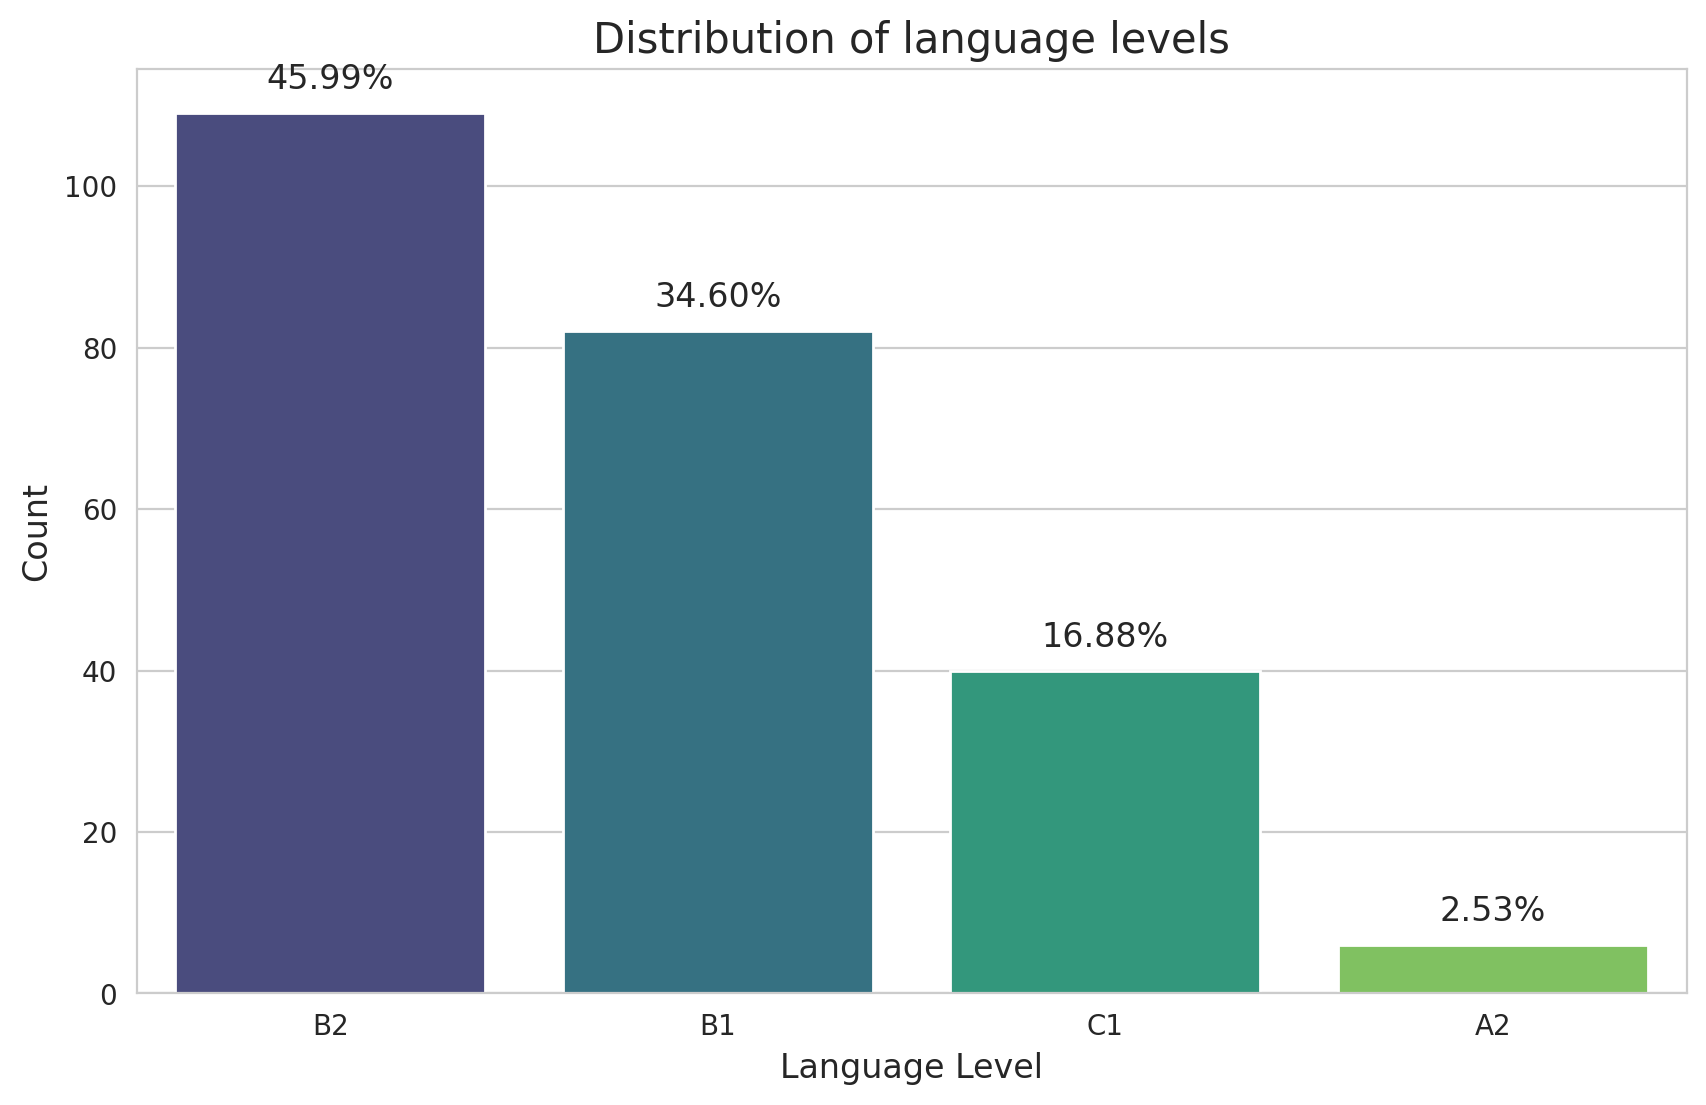

In [49]:
# Displaying the count for each class
# Setting the style to "seaborn" for improved plot appearance
sns.set_style("whitegrid")

# Creating a histogram
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='level', order=df['level'].value_counts().index, palette='viridis')

# Setting the title and labels for the histogram
plt.title('Distribution of language levels', fontsize=15)
plt.xlabel('Language Level', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Adding annotations above each bar
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(100*height/total),
            ha="center", fontsize=12)

# Displaying the histogram
plt.show()

### Splitting the data into the target feature and features.


In [50]:
X = df.drop('level', axis=1)
y = df['level']

### Splitting the data into training and testing sets with stratification.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model selection and training.

### Training and hyperparameter tuning for RandomForestClassifier model.

In [52]:
rf_model = RandomForestClassifier(random_state=2023)
hyperparams = {'max_depth': [5, 6, 7, 8],
               'n_estimators': [50, 100, 150],
               'random_state': [2023]}

clf = GridSearchCV(rf_model, hyperparams, scoring='accuracy')
clf.fit(X_train, y_train)

best_params = clf.best_params_
rf_best_model = clf.best_estimator_

# Evaluation of metrics on the best model
y_pred = rf_best_model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculation of standard deviation for the best model
cv_results = clf.cv_results_
best_std = cv_results['std_test_score'][clf.best_index_]

print("Best parameters for the RandomForestClassifier model:", best_params)
print("Standard deviation for the best RandomForestClassifier model:", (best_std).round(2))
print("Balanced accuracy metric for the best RandomForestClassifier model:", (balanced_accuracy).round(2))
print("Accuracy metric for the best RandomForestClassifier model:", (accuracy).round(2))
print("F1 metric for the best RandomForestClassifier model:", (f1).round(2))

Best parameters for the RandomForestClassifier model: {'max_depth': 8, 'n_estimators': 50, 'random_state': 2023}
Standard deviation for the best RandomForestClassifier model: 0.03
Balanced accuracy metric for the best RandomForestClassifier model: 0.8
Accuracy metric for the best RandomForestClassifier model: 0.79
F1 metric for the best RandomForestClassifier model: 0.79


### Training and hyperparameter tuning for CatBoostClassifier model.

In [53]:
# Creating Pool
train_pool = Pool(data=X_train, label=y_train)

def objective(trial):
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.03, 0.05, 0.07, 0.1])
    depth = trial.suggest_categorical("depth", [4, 6, 8])
    iterations = trial.suggest_categorical("iterations", [750, 1000, 1500])
    l2_leaf_reg = trial.suggest_categorical("l2_leaf_reg", [2, 3, 5])

    model = CatBoostClassifier(
        learning_rate=learning_rate,
        depth=depth,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        random_seed=2023,
        eval_metric='Accuracy',
        verbose=0
    )
    model.fit(train_pool)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

# Getting the best parameters and metrics
best_params_cb = study.best_params
best_model_cb = CatBoostClassifier(**best_params_cb, random_seed=2023, verbose=0, eval_metric='Accuracy')
best_model_cb.fit(train_pool)

y_pred_cb = best_model_cb.predict(X_test)
balanced_accuracy_cb = balanced_accuracy_score(y_test, y_pred_cb)
f1_cb = f1_score(y_test, y_pred_cb, average='weighted')

print(f"Best parameters for the CatBoostClassifier model: {best_params_cb}")
print(f"Balanced accuracy metric for the best CatBoostClassifier model: {balanced_accuracy_cb:.2f}")
print(f"F1 metric for the best CatBoostClassifier model: {f1_cb:.2f}")

[I 2023-11-19 10:45:07,151] A new study created in memory with name: no-name-a2496568-c2be-4326-b535-7e65729c14a5
[I 2023-11-19 10:45:33,863] Trial 0 finished with value: 0.8125 and parameters: {'learning_rate': 0.1, 'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.8125.
[I 2023-11-19 10:45:37,449] Trial 1 finished with value: 0.8125 and parameters: {'learning_rate': 0.01, 'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 5}. Best is trial 0 with value: 0.8125.
[I 2023-11-19 10:45:37,586] Trial 2 finished with value: 0.7916666666666666 and parameters: {'learning_rate': 0.05, 'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 2}. Best is trial 0 with value: 0.8125.
[I 2023-11-19 10:45:42,143] Trial 3 finished with value: 0.7916666666666666 and parameters: {'learning_rate': 0.05, 'depth': 6, 'iterations': 750, 'l2_leaf_reg': 2}. Best is trial 0 with value: 0.8125.
[I 2023-11-19 10:45:47,170] Trial 5 finished with value: 0.7916666666666666 and parameters: {'learni

Best parameters for the CatBoostClassifier model: {'learning_rate': 0.03, 'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 2}
Balanced accuracy metric for the best CatBoostClassifier model: 0.85
F1 metric for the best CatBoostClassifier model: 0.83


**Conclusion:** The CatBoostClassifier model demonstrated the best metrics.

## Best model testing on test data.

In [54]:
%%time

# Creating model with the best hyperparameters

cb_model = CatBoostClassifier(learning_rate=0.01, depth=8, iterations=1000, l2_leaf_reg=5, eval_metric='Accuracy', verbose=False, random_seed=2023)

# Training the model on training data
cb_model.fit(X_train, y_train)

# Making predictions on test dataset
y_pred = cb_model.predict(X_test)

# Calculating metrics on test dataset
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

# Printing the results
print("Balanced Accuracy of the CatBoostClassifier model:", balanced_accuracy.round(2))
print("F1 Score of the CatBoostClassifier model:", f1.round(2))

Balanced Accuracy of the CatBoostClassifier model: 0.83
F1 Score of the CatBoostClassifier model: 0.81
CPU times: user 21.4 s, sys: 290 ms, total: 21.7 s
Wall time: 14.9 s


## Building confusion matrix.

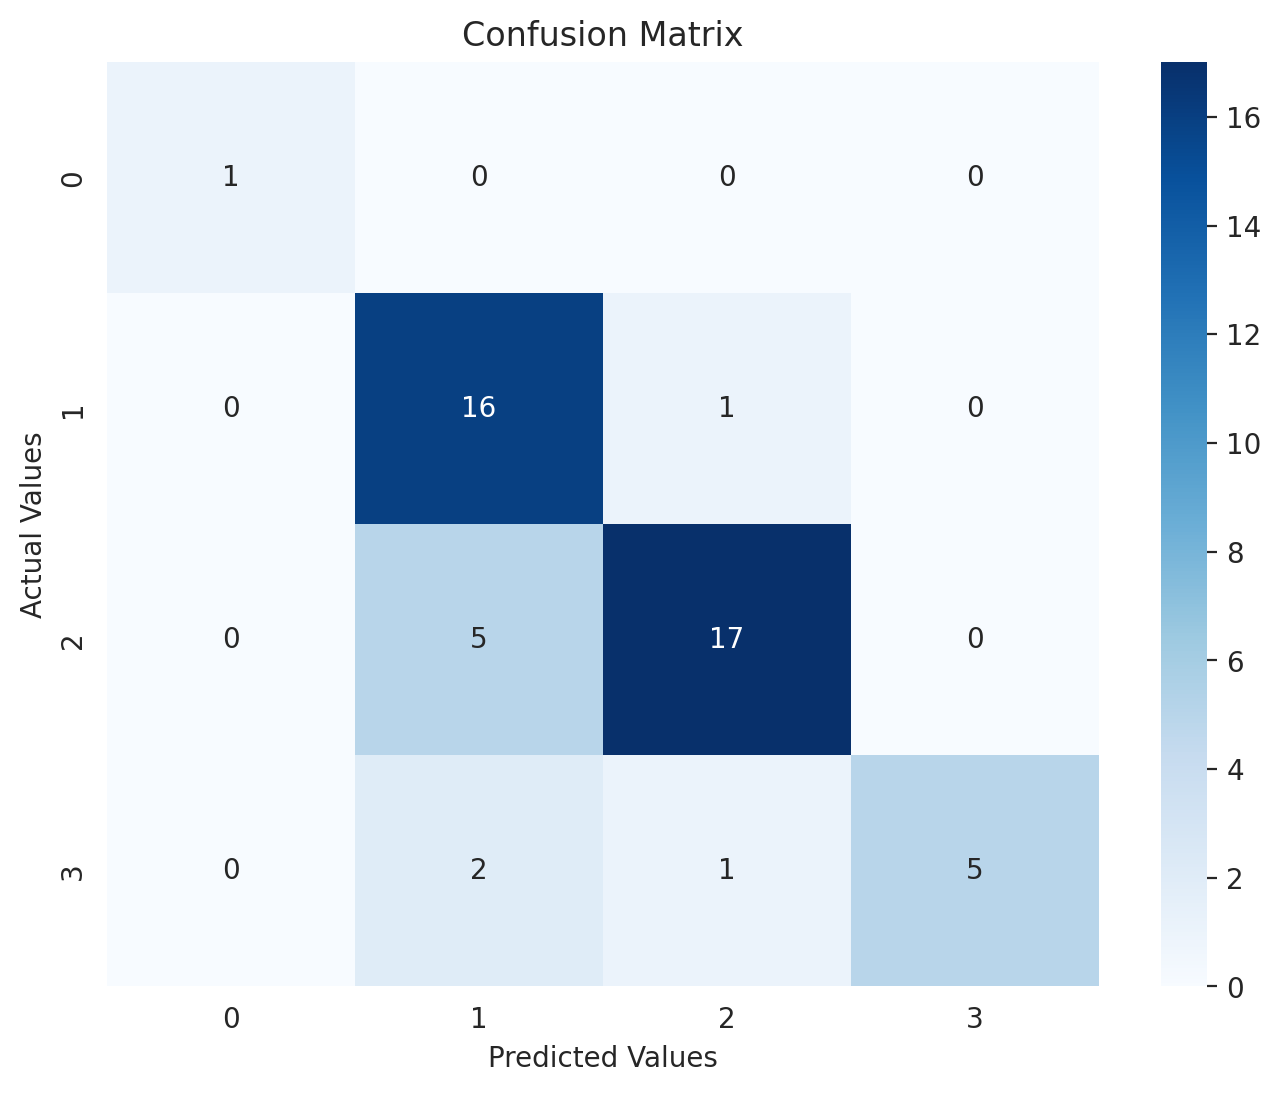

In [55]:
# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.show()

## Calculating Feature Importance.

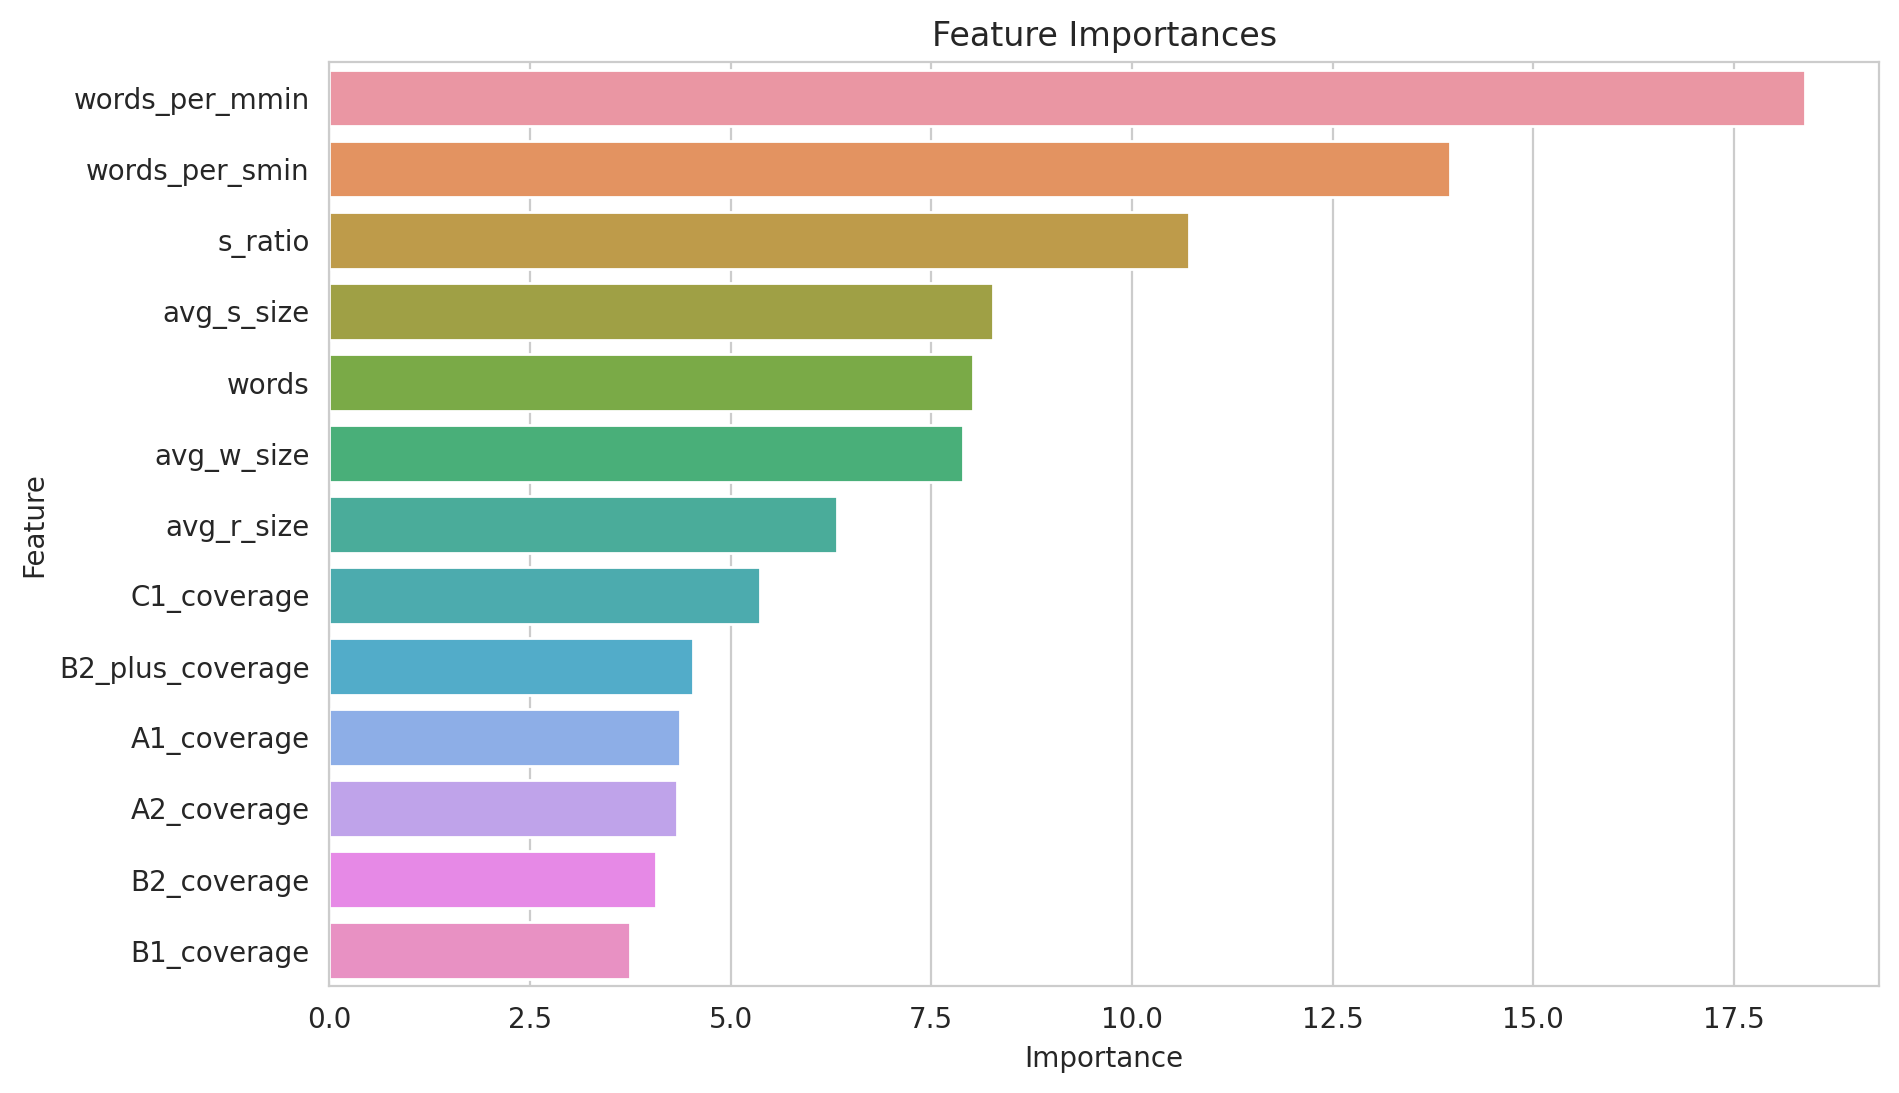

In [56]:
# Retrieving feature importance
feature_importances = cb_model.feature_importances_

# Creating a DataFrame with feature information and their importance
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sorting by importance
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Displaying a bar plot of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Conclusion:

- **The best model has confirmed its accuracy on the test data.**
- **The most significant features are as follows: the number of unique words per minute in the movie, the number of unique words per minute in the subtitles, and the ratio of subtitle duration to movie duration.**

## Project Summary Report.

Within the project, the following main stages were completed:

- Searching for subtitle files for each annotated film using pathlib and difflib libraries.
- Extraction of the text from subtitle files using the pysrt library. The challenge here was dealing with different file encodings. The solution was to create a function to determine the encoding of each file and then use the appropriate encoding when working with the files.
- Cleaning the text by removing unnecessary characters, stop words, and names, followed by lemmatizing words in the text. Nltk library was used for cleaning the text from stop words and names, and SpaCy was used for lemmatization.
- Extraction of list of words by CEFR levels from Oxford files in pdf format using the fitz library.
- Feature engineering stage: the dataset was enriched with columns for the following features:
  - Number of unique words
  - Duration of subtitles in the film
  - Duration of the film
  - Proportion of subtitle duration to film duration
  - Number of unique words per minute of subtitles
  - Number of unique words per minute of the film
  - Average word length in the film (in characters)
  - Average sentence length in the film (in words)
  - Average length of lines in the film (in words)
  - Lexical coverage of unique words from the film by CEFR word lists (A1, A2, B1, B2, B2+, C1).

- Two models were then trained with hyperparameter tuning using grid_search and optuna: RandomForestClassifier and CatboostClassifier. The folloiwng metrics were used: balanced accuracy and f1 score. The models trained on features that included vectors of cleaned texts performed significantly worse.

- When trained on features excluding vectors of cleaned texts, both models achieved a balanced accuracy metric of no less than 0.75. The CatboostClassifier model performed the best with a balanced accuracy of approximately 0.83.

- The most important features for the best model are the number of unique words per minute in the film, the number of unique words per minute in the subtitles, and the proportion of subtitle duration to film duration.
